# `torchdyn`Quickstart

`torchdyn` is a PyTorch library dedicated to neural differential equations and equilibrium models.

Central to the `torchdyn` approach are continuous and implicit neural networks, where *depth* is taken to its infinite limit.

This notebook serves as a gentle introduction to NeuralODE, concluding with a small overview of `torchdyn` features.

In [1]:
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *

%load_ext autoreload
%autoreload 2

In [2]:
# quick run for automated notebook validation
dry_run = False

## Generate data from a static toy dataset 

We’ll be generating data from toy datasets. In torchdyn, we provide a wide range of datasets often use to benchmark and understand Neural ODEs. Here we will use the classic moons dataset and train a Neural ODE for binary classification

In [5]:
d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='moons')        

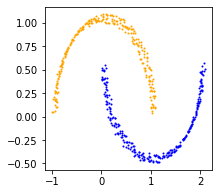

In [6]:
import matplotlib.pyplot as plt

colors = ['orange', 'blue'] 
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])

Generated data can be easily loaded in the dataloader with standard `PyTorch` calls

In [7]:
import torch
import torch.utils.data as data
device = torch.device("cpu") # all of this works in GPU as well :)

X_train = torch.Tensor(X).to(device)
y_train = torch.LongTensor(yn.long()).to(device)
train = data.TensorDataset(X_train, y_train)
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True)

We utilize [Pytorch Lightning](https://github.com/PyTorchLightning/pytorch-lightning) to handle training loops, logging and general bookkeeping. This allows `torchdyn` and Neural Differential Equations to have access to modern best practices for training and experiment reproducibility. 

In particular, we combine modular `torchdyn` models with `LightningModules` via a `Learner` class:

In [8]:
import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span
    
    def forward(self, x):
        return self.model(x)
    
    def training_step(self, batch, batch_idx):
        x, y = batch      
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}   
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader

## Define a  Neural ODE

Analogously to most forward neural models we want to realize a map 

$$
        x \mapsto \hat y
$$

where  $\hat y$ becomes the best approximation of a true output $y$ given an input $x$.
In torchdyn you can define very simple Neural ODE models of the form 

$$ \left\{
    \begin{aligned}
        \dot{z}(t) &= f(z(t), \theta)\\
        z(0) &= x\\
        \hat y & = z(1)
    \end{aligned}
    \right. \quad t\in[0,1]
$$

by just specifying a neural network $f$ and giving some simple settings.

**Note:** This Neural ODE model is of *depth-invariant* type as neither $f$ explicitly depend on $s$ nor the parameters $\theta$ are depth-varying. Together with their *depth-variant* counterpart with $s$ concatenated in the vector field was first proposed and implemented by [[Chen T. Q. et al, 2018]](https://arxiv.org/abs/1806.07366)

### Define the vector field (DEFunc) 

The first step is to define any PyTorch `torch.nn.Module`. This takes the role of the Neural ODE vector field $f(h,\theta)$ 

In [9]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)                       
    )
t_span = torch.linspace(0, 1, 5)

In this case we chose $f$ to be a simple MLP with one hidden layer and $\tanh$ activation

### Define the NeuralDE

The final step to define a Neural ODE is to instantiate the torchdyn's class `NeuralDE` passing some customization arguments and `f` itself.

In this case we specify:
* we compute backward gradients with the `'adjoint'` method.
* we will use the `'dopri5'` (Dormand-Prince) ODE solver from `torchdyn`, with no additional options;

In [10]:
model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


## Train the Model

With the same forward method of `NeuralDE` objects you can quickly evaluate the entire trajectory of each data point in `X_train` on an interval `t_span`

In [13]:
t_span = torch.linspace(0,1,100)
t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()

The numerical method used to solve a `NeuralODE` have great effect on its speed. Try retraining with the following

In [12]:
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)                       
    )

model = NeuralODE(f, sensitivity='adjoint', solver='rk4', solver_adjoint='dopri5', atol_adjoint=1e-4, rtol_adjoint=1e-4).to(device)

learn = Learner(t_span, model)
if dry_run: trainer = pl.Trainer(min_epochs=1, max_epochs=1)
else: trainer = pl.Trainer(min_epochs=200, max_epochs=300)
trainer.fit(learn)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/zdenek-syntensor/_projects/syntensor/torchdyn/tutorials/lightning_logs

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 82    
------------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


/Users/zdenek-syntensor/Library/Caches/pypoetry/virtualenvs/torchdyn-s0ChYSZC-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:240: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 10 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/zdenek-syntensor/Library/Caches/pypoetry/virtualenvs/torchdyn-s0ChYSZC-py3.9/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1927: PossibleUserWarning: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

### Plot the Training Results

We can first plot the trajectories of the data points in the depth domain $s$

In [14]:
t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cpu()

Text(0.5, 1.0, 'Dimension 1')

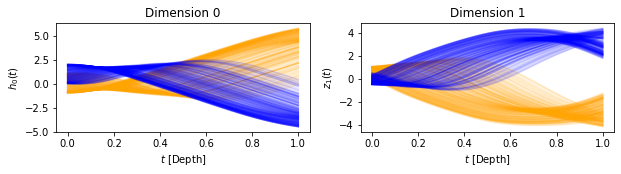

In [15]:
color=['orange', 'blue']

fig = plt.figure(figsize=(10,2))
ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122)
for i in range(500):
    ax0.plot(t_span, trajectory[:,i,0], color=color[int(yn[i])], alpha=.1);
    ax1.plot(t_span, trajectory[:,i,1], color=color[int(yn[i])], alpha=.1);
ax0.set_xlabel(r"$t$ [Depth]") ; ax0.set_ylabel(r"$h_0(t)$")
ax1.set_xlabel(r"$t$ [Depth]") ; ax1.set_ylabel(r"$z_1(t)$")
ax0.set_title("Dimension 0") ; ax1.set_title("Dimension 1")

Then the trajectory in the *state-space*

As you can see, the Neural ODE steers the data-points into regions of null loss with a continuous flow in the depth domain. Finally, we can also plot the learned vector field $f$

/Users/zdenek-syntensor/Library/Caches/pypoetry/virtualenvs/torchdyn-s0ChYSZC-py3.9/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/distiller/project/pytorch/aten/src/ATen/native/TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


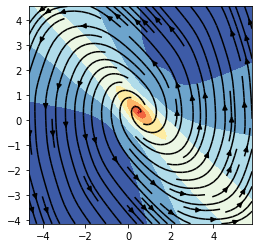

In [16]:
# evaluate vector field
n_pts = 50
x = torch.linspace(trajectory[:,:,0].min(), trajectory[:,:,0].max(), n_pts)
y = torch.linspace(trajectory[:,:,1].min(), trajectory[:,:,1].max(), n_pts)
X, Y = torch.meshgrid(x, y) ; z = torch.cat([X.reshape(-1,1), Y.reshape(-1,1)], 1)
f = model.vf(0,z.to(device)).cpu().detach()
fx, fy = f[:,0], f[:,1] ; fx, fy = fx.reshape(n_pts , n_pts), fy.reshape(n_pts, n_pts)
# plot vector field and its intensity
fig = plt.figure(figsize=(4, 4)) ; ax = fig.add_subplot(111)
ax.streamplot(X.numpy().T, Y.numpy().T, fx.numpy().T, fy.numpy().T, color='black')
ax.contourf(X.T, Y.T, torch.sqrt(fx.T**2+fy.T**2), cmap='RdYlBu')

**Sweet! You trained your first Neural ODEs! Now you can proceed and learn about more advanced models with the next tutorials**

## More about `torchdyn`


In [17]:
import time
from torchdyn.numerics import Euler, RungeKutta4, Tsitouras45, DormandPrince45, MSZero, Euler, HyperEuler
from torchdyn.numerics import odeint, odeint_mshooting, Lorenz
from torchdyn.core import ODEProblem, MultipleShootingProblem

But wait! `torchdyn` has way more than `NeuralODEs`. If you wish to solve generic differential equations parallelizable both in space (initial conditions) as well in time, with parallel, but do not need neural networks inside the vector field, you can use our functional API like so:

In [18]:
x0 = torch.randn(8, 3) + 15
t_span = torch.linspace(0, 3, 2000)
sys = Lorenz()

In [19]:
t0 = time.time()
t_eval, accurate_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-6, rtol=1e-6)
accurate_sol_time = time.time() - t0

t0 = time.time()
t_eval, base_sol = odeint(sys, x0, t_span, solver='euler')
base_sol_time = time.time() - t0

t0 = time.time()
t_eval, rk4_sol = odeint(sys, x0, t_span, solver='rk4')
rk4_sol_time = time.time() - t0

t0 = time.time()
t_eval, dp5_low_sol = odeint(sys, x0, t_span, solver='dopri5', atol=1e-3, rtol=1e-3)
dp5_low_time = time.time() - t0

t0 = time.time()
t_eval, ms_sol = odeint_mshooting(sys, x0, t_span, solver='mszero', fine_steps=2, maxiter=4)
ms_sol_time = time.time() - t0

AttributeError: 'MSZero' object has no attribute 'coarse_method'

Alternatively, you can wrap your vector field in a specific `*Problem` to perform sensitivity analysis and optimize for terminal as well as integral objectives:

In [20]:
prob = ODEProblem(sys, sensitivity='interpolated_adjoint', solver='dopri5', atol=1e-3, rtol=1e-3, 
                  solver_adjoint='tsit5', atol_adjoint=1e-3, rtol_adjoint=1e-3)
t0 = time.time()
t_eval, sol_torchdyn = prob.odeint(x0, t_span)
t_end1 = time.time() - t0

Our numerics suite includes other tools, such as a `odeint_hybrid` for hybrid systems (potentially stochastic and multi-mode). We have built our numerics suite from the ground up to be compatible with hybridized methods such as hypersolvers, where a base solver works in tandem with neural approximators to increase accuracy while retaining improved extrapolation capabilities. In fact, these methods can be called from the same API:

In [21]:
class VanillaHyperNet(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net
        for p in self.net.parameters():
            torch.nn.init.uniform_(p, 0, 1e-5)
    def forward(self, t, x):
        return self.net(x)

In [22]:
net = nn.Sequential(nn.Linear(3, 64), nn.Softplus(), nn.Linear(64, 64), nn.Softplus(), nn.Linear(64, 3))
hypersolver = HyperEuler(VanillaHyperNet(net))
t_eval, sol = odeint(sys, x0, t_span, solver=hypersolver) # note: this has to be trained!

We also provide an extensive set of tutorial subdivided into modules. Each tutorials deals with a specific aspect of continuous or implicit models, or showcases applications (control, generative modeling, forecasting, optimal control of ODEs and PDEs, graph node classification). Check `torchdyn/tutorials` for more information.